## Load the packages & data

In [34]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statistics

In [11]:
df_business = pd.read_json('yelp_academic_dataset_business.json', lines=True)
df_checkin = pd.read_json('yelp_academic_dataset_checkin.json', lines=True)
df_tip = pd.read_json('yelp_academic_dataset_tip.json', lines=True)
# load user data from 
df_user = joblib.load('user_no_friend.py') 
df_review = joblib.load('review_no_text.py') 

## Basic descriptives of variables in business dataset
1. business by city/state
2. distribution of stars
3. distribution of review counts
4. percentage of open/close
5. a list of top 10 categories & its percentage

In [12]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
# NaN is easier to deal with. Covert None to NaN.
df = df.fillna(value=np.nan)
df.info()

In [26]:
# basic 1: # business by city
df_business['city'].value_counts()[:10]/len(df_business)*100

Philadelphia     9.690314
Tucson           6.152475
Tampa            6.019448
Indianapolis     5.015099
Nashville        4.636638
New Orleans      4.129807
Reno             3.947561
Edmonton         3.361579
Saint Louis      3.210594
Santa Barbara    2.546792
Name: city, dtype: float64

In [27]:
# basic 1: # business by state
df_business['state'].value_counts()[:10]/len(df_business)*100

PA    22.640443
FL    17.512937
TN     8.018837
IN     7.480744
MO     7.258590
LA     6.600774
AZ     6.592793
NJ     5.677570
NV     5.131497
AB     3.706783
Name: state, dtype: float64

In [33]:
df_business['stars']

0         5.0
1         3.0
2         3.5
3         4.0
4         4.5
         ... 
150341    3.0
150342    4.0
150343    3.5
150344    4.0
150345    4.5
Name: stars, Length: 150346, dtype: float64

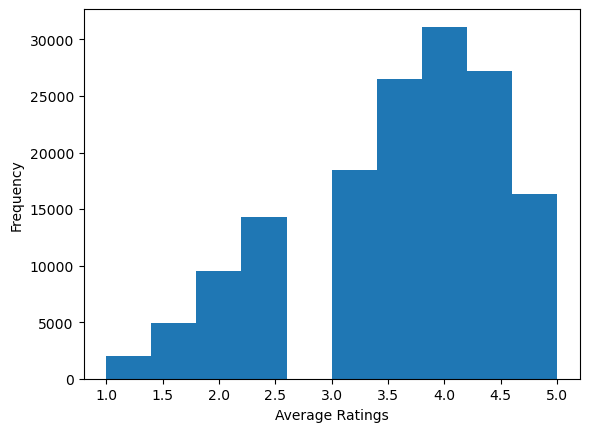

4.0

In [35]:
# basic 2: distribution of stars
plt.figure()
plt.hist(df_business['stars'], bins = 10)
plt.xlabel('Average Ratings') # The ratings are aggregated results but not strictly average. 
plt.ylabel('Frequency')
plt.show()

statistics.mode(df_business['stars']) # mode = 4

## Findings:
The distribution is skewed toward left and peaking at 4 star, meaning more higher rating. The ratings are aggregated results but not strictly average. Because ratings are in a incremental scale of 0.5 from 1-5.

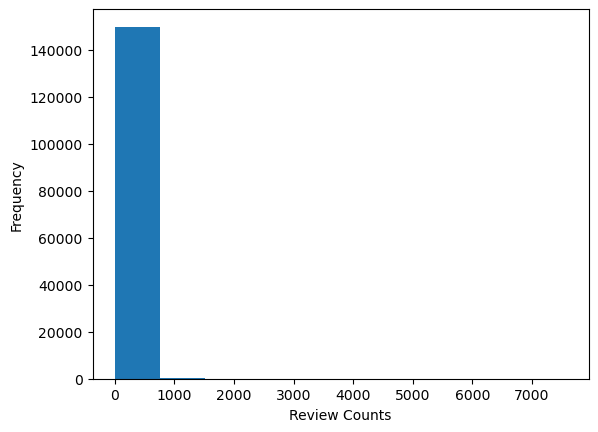

In [36]:
# basic 3: distribution of review counts
plt.figure()
plt.hist(df_business['review_count'], bins = 10)
plt.xlabel('Review Counts') # The ratings are aggregated results but not strictly average. 
plt.ylabel('Frequency')
plt.show()
# This plot is not informative => categorize the values into several bins

In [54]:
df_business['label'] = pd.cut(x=df_business['review_count'], bins=[5, 10, 20, 50, 100, 500, 1000, 10000],
                     labels=[ '5-10', '11-20', '21-50', '51-100', '101-500', '501-1000', '1001-10000'])

df_business['label'].value_counts()/len(label)*100

5-10          28.004071
11-20         22.363748
21-50         20.585849
51-100         9.477472
101-500        8.747822
501-1000       0.687082
1001-10000     0.209517
Name: label, dtype: float64

In [55]:
# basic 4: percentage of open/close
df_business['is_open'].value_counts()/len(df_business)*100

1    79.615021
0    20.384979
Name: is_open, dtype: float64

In [56]:
# check the average ratings of open vs. close
df_business.groupby('is_open')['stars'].mean()

is_open
0    3.510082
1    3.618908
Name: stars, dtype: float64

### For categories, count frequencies and get a list of most common categories

In [61]:
category = []
# write a loop as above, skip when it's NaN
for i in range(len(df_business['categories'])):
    #print(i)
    new_add = df_business['categories'][i]
    if pd.isna(new_add):
        continue
    else:
        category.extend(new_add.split(","))

def remove(string):
    return string.replace(" ", "")

category2 = []
for item in category:
    category2.append(remove(item))

from collections import Counter
category_list = Counter(category2).most_common()
# Top 20 categories
category_list[:20]

[('Restaurants', 52268),
 ('Food', 27781),
 ('Shopping', 24395),
 ('HomeServices', 14356),
 ('Beauty&Spas', 14292),
 ('Nightlife', 12281),
 ('Health&Medical', 11890),
 ('LocalServices', 11198),
 ('Bars', 11065),
 ('Automotive', 10773),
 ('EventPlanning&Services', 9895),
 ('Sandwiches', 8366),
 ('American(Traditional)', 8139),
 ('ActiveLife', 7687),
 ('Pizza', 7093),
 ('Coffee&Tea', 6703),
 ('FastFood', 6472),
 ('Breakfast&Brunch', 6239),
 ('American(New)', 6097),
 ('Hotels&Travel', 5857)]